In [1]:
# Reading in data and verify it is the same set as the book
path1 = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/offline.final.trace.txt'
path2 = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/offline_data.txt"

data = readLines(path1)

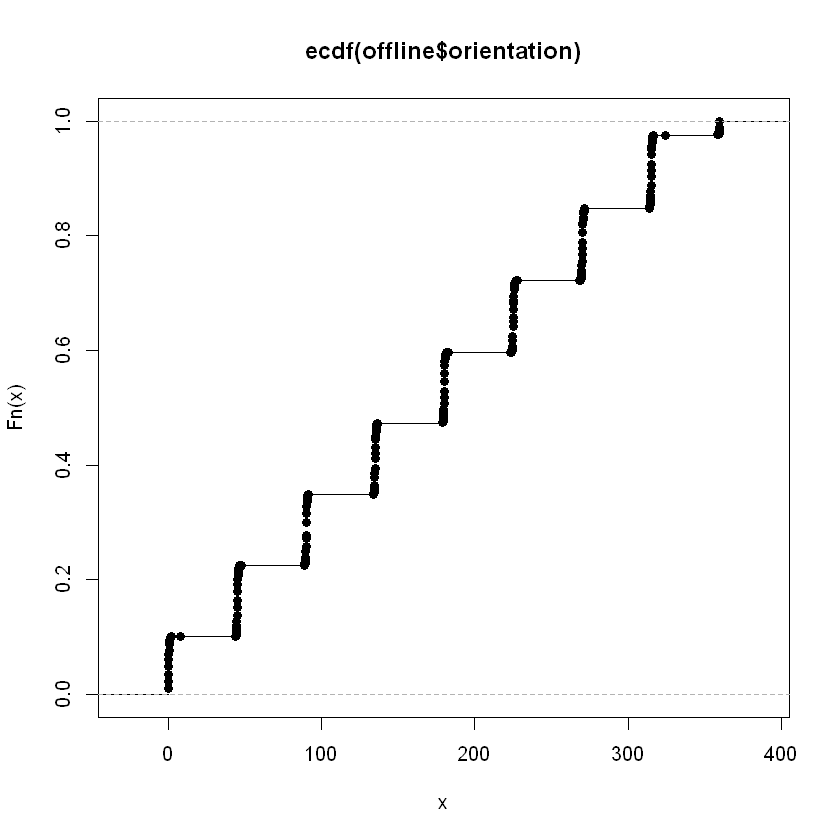

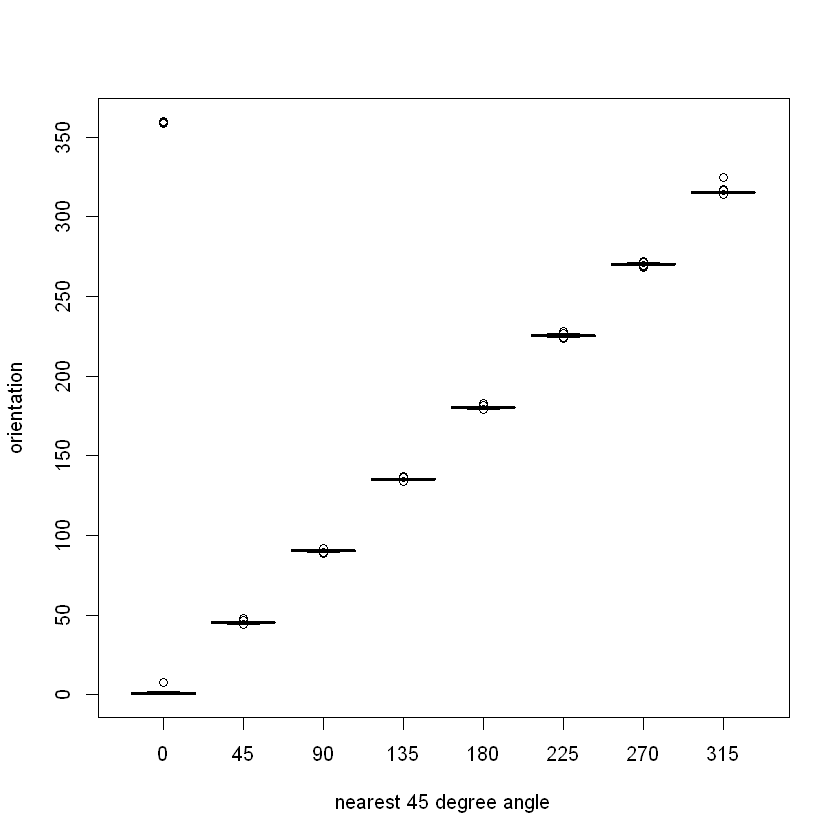

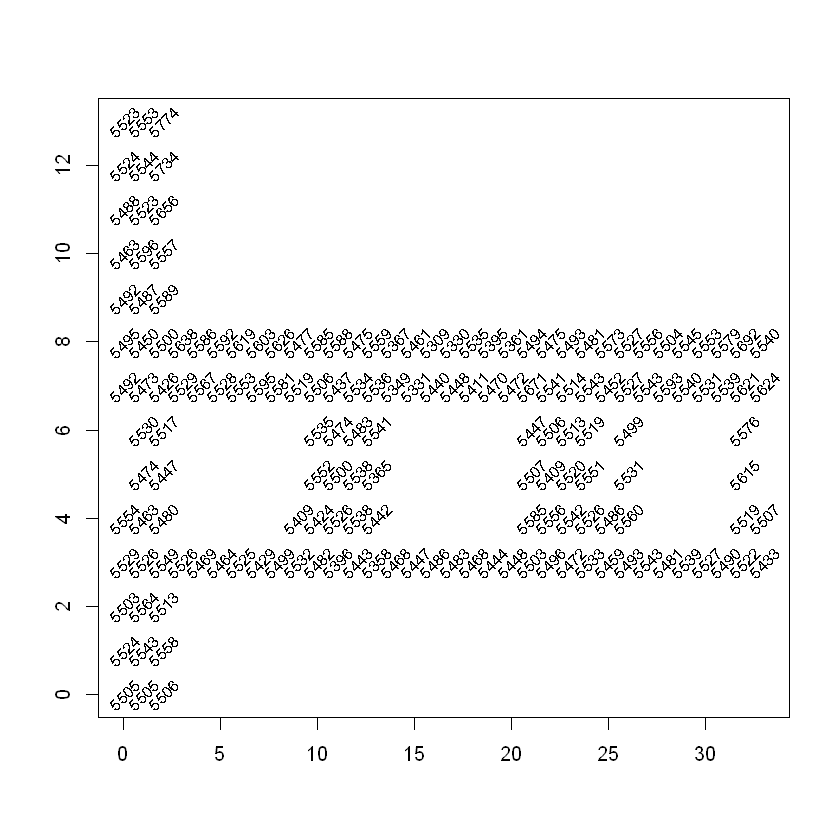

In [2]:
getData = function(data){
    options(error = recover, warn=1)
    lines = data[substr(data,1,1) != "#"]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), stringsAsFactors = FALSE)
    names(offline) = c("time", "scanMac", "posX", "posY", "posZ", "orientation", "mac", "signal", "channel", "type")
    numVars = c("time", "posX", "posY", "posZ", "orientation", "signal")
    offline[numVars] = lapply(offline[numVars], as.numeric)
    offline = offline[offline$type == "3",]
    offline = offline[, "type" != names(offline)]
    offline$rawtime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    offline = offline[, !(names(offline) %in% c("scanMac", "posZ"))]
    plot(ecdf(offline$orientation))
    offline$angle = roundOrientation(offline$orientation)
    with(offline, boxplot(orientation ~ angle, xlab = "nearest 45 degree angle", ylab="orientation"))
    submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
    offline = offline[offline$mac %in% submac,]
    offline = offline[, "channel" != names(offline)]
    locDF = with(offline, by(offline, list(posX, posY), function(x) x))
    locDF = locDF[ !sapply(locDF, is.null)]
    locCounts = sapply(locDF, function(df) c(df[1, c("posX", "posY")], count= nrow(df)))
    locCounts = t(locCounts)
    plot(locCounts, type="n", xlab="", ylab="")
    text(locCounts, labels = locCounts[,3], cex=0.8, srt = 45)
    return(offline)
}

processLine = function(x){
    tokens = strsplit(x, "[;=,]")[[1]]
    
    if (length(tokens) == 10)
        return(NULL)
    tmp = matrix(tokens[-(1:10)], ncol=4, byrow = TRUE)
    cbind(matrix(tokens[c(2,4,6:8,10)], nrow = nrow(tmp), ncol=6, byrow=TRUE), tmp)
}

roundOrientation = function(angles) {
    refs = seq(0, by = 45, length = 9)
    q = sapply(angles, function(o) which.min(abs(o-refs)))
    c(refs[1:8], 0)[q]
}
               
offline = getData(data)

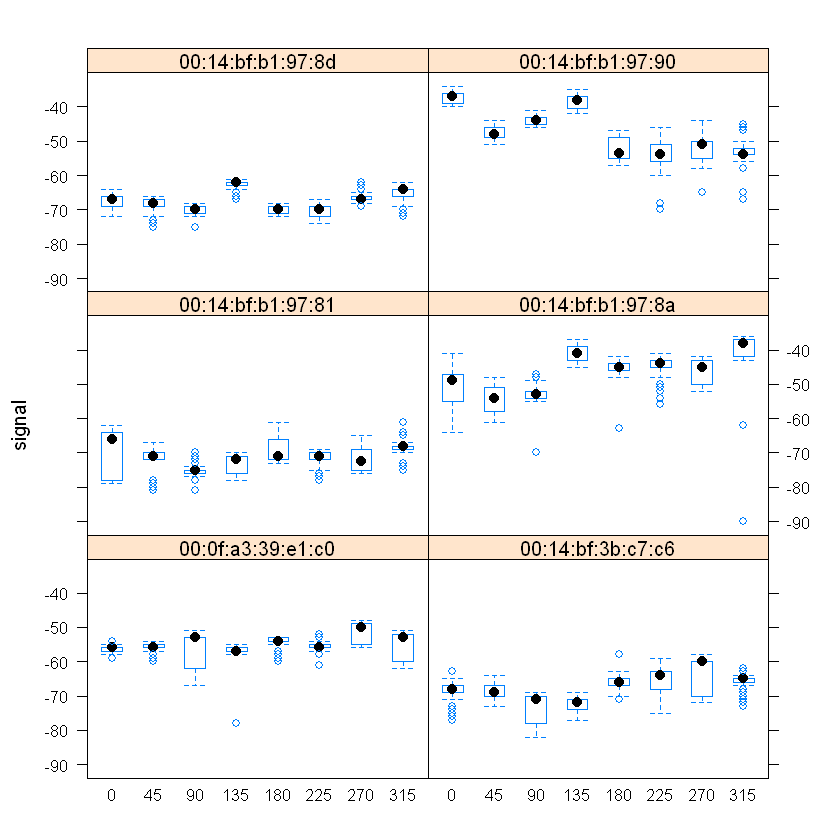

In [3]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline,
      subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:dd:cd", layout = c(2,3))

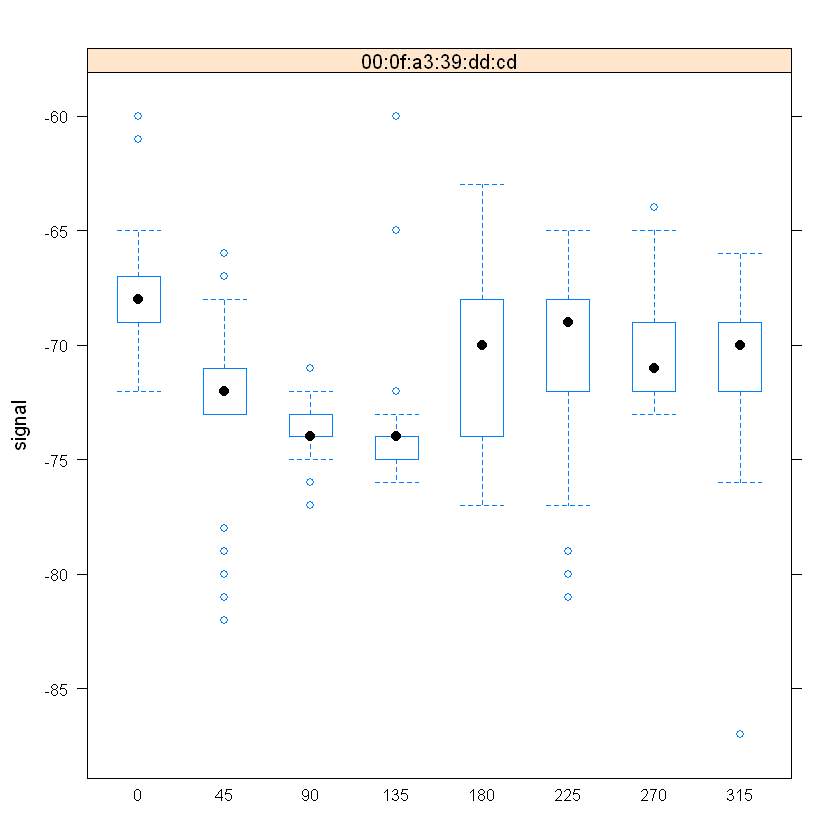

In [4]:
# plot missing MAC address

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline,
      subset = posX == 2 & posY == 12 & mac == "00:0f:a3:39:dd:cd")

In [5]:
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -98.00  -67.00  -59.00  -59.92  -53.00  -25.00 

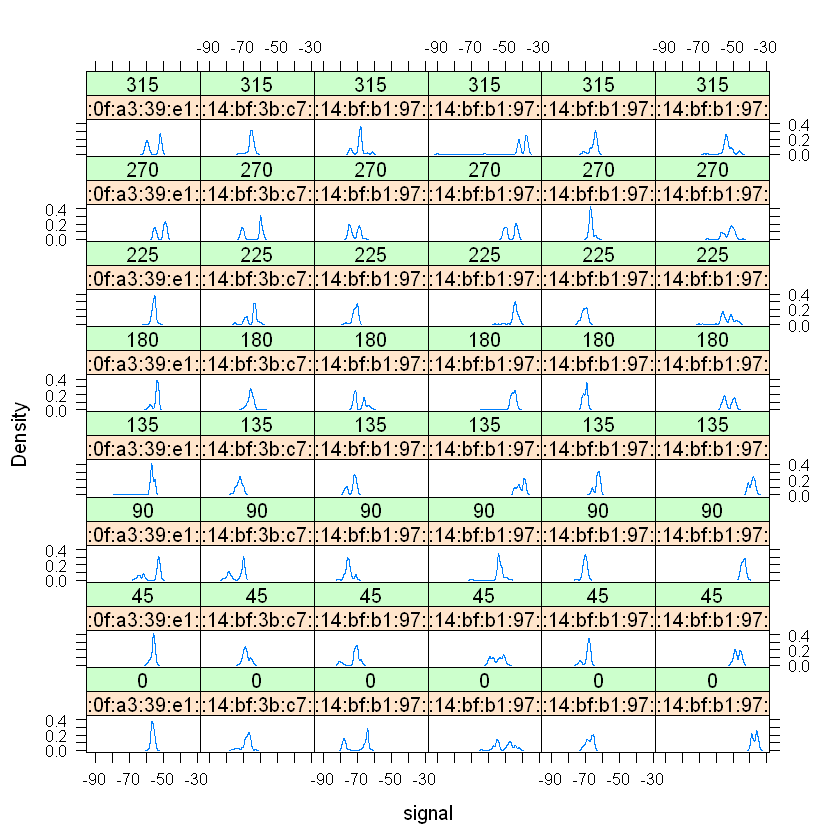

In [6]:
densityplot( ~ signal | mac + factor(angle), data = offline,
           subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:dd:cd",
           bw = 0.5, plot.points = FALSE)

In [7]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")
byLocAngleAP = with(offline, list(posXY, angle, mac), function(x) x)

In [8]:
signalSummary = lapply(byLocAngleAP, function(oneLoc){
    ans = oneLoc[1, ]
    ans$medSignal = median(oneLoc$signal)
    ans$avgSignal = mean(oneLoc$signal)
    ans$num = length(oneLoc$signal)
    ans$sdSignal = sd(oneLoc$signal)
    ans$iqrSignal = IQR(oneLoc$signal)
    ans
})

ERROR: Error in oneLoc[1, ]: incorrect number of dimensions


In [9]:
offlineSummary = do.call("rbind", signalSummary)

ERROR: Error in do.call("rbind", signalSummary): object 'signalSummary' not found


In [10]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
      data = offlineSummary,
      subset = mac != "00:0f:a3:39:dd:cd",
      xlab = "Mean Signal",
      ylab = "SD Signal")

ERROR: Error in eval(substitute(groups), data, environment(formula)): object 'offlineSummary' not found
